In [1]:
%load_ext autoreload
%autoreload 2

In [232]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import glob
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np

In [233]:
DATASET_NAME = "mpii"  # mpii, coco

In [234]:
root = f"/hdd/mliuzzolino/CascadedPoseEstimation/results/{DATASET_NAME}"
all_result_paths = glob.glob(f"{root}/*/*")

df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  basename = os.path.basename(os.path.dirname(path))
  basename = basename.replace("pose_", "")
  try:
    model, td_key, mode_key = basename.split("__")
    td_key = float(td_key.split("(")[1].replace(")", ""))
  except:
    model = basename.split("__")[0]
    td_key = ""
    mode_key = "baseline"
  model = model.replace("_", "")
  
  for t, val in enumerate(result):
    df_dict["model"].append(model)
    df_dict["t"].append(t)
    df_dict["td"].append(td_key)
    df_dict["mode"].append(mode_key)
    df_dict["val"].append(val)
df = pd.DataFrame(df_dict)

In [235]:
MODEL_NAME = "resnet18"

In [236]:
def split_model(df, model_name=None):
  if model_name:
    model_df = df[df.model==model_name]
  else:
    model_df = df.copy()
  td_model_df = model_df[~model_df["mode"].str.contains("baseline")]
  baseline_df = model_df[model_df["mode"].str.contains("baseline")]
  return td_model_df, baseline_df

In [237]:
def make_color_lookup(df):
  unique_tds = np.sort(td_model_df.td.unique())
  cmap = plt.cm.magma(np.linspace(0, 1, len(unique_tds)+2))[1:-1][:,:3]
  color_lookup = {key: cmap[i] for i, key in enumerate(unique_tds)}
  return color_lookup

In [238]:
def plot_figure(td_model_df, baseline_df, dataset_name, ylim_min=None, ylim_max=None):
  model_name = td_model_df.model.iloc[0]
  color_lookup = make_color_lookup(td_model_df)
  plt.figure(figsize=(8,3))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])

  # TD Model curves
  for i, (mode_key, mode_df) in enumerate(td_model_df.groupby("mode")):
    mode_df = mode_df.sort_values("td")
    ls = "--" if mode_key == "serial" else "-"
    for td_key, td_df in mode_df.groupby("td"):
      asymptotic_val = td_df[td_df.t==td_df.t.max()].val.iloc[0]
      td_df["td"] = [
          f"CascadedTD({td_key}), {mode_key}: {asymptotic_val:0.2f}%" 
          for td_key in td_df["td"]
      ]
    
      
      color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      g = sns.lineplot(x="t", 
                       y="val", 
                       hue="td", 
                       data=td_df,
                       palette=palette, 
                       linestyle=ls,
                       linewidth=2.5)

  plt.suptitle(f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set", fontsize=10)
  g.set_title(f"Avg Performance over All Joints", fontsize=8)
  g.set_xlabel("Timestep, t")
  g.set_ylabel("Accuracy (%)")

  handles, labels = g.get_legend_handles_labels()
  # Baseline
  baseline_val = float(baseline_df.iloc[0].get("val"))
  baseline_line = Line2D([0], [0], label='Baseline', color='k', alpha=0.4, linestyle="--")
  handles.append(baseline_line)
  labels.append(f"Baseline: {baseline_val:0.2f}%")

  for i, (handle, label) in enumerate(zip(handles, labels)):
    if "serial" in label:
      handle.set_linestyle("--")
  
  plt.axhline(baseline_val, xmin=0, xmax=5, c="k", alpha=0.4, ls="--", lw=2)
  
  if ylim_max:
    plt.ylim(ylim_min, ylim_max)
    
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  
  leg = plt.legend(handles, labels, loc="lower right", prop={'size': 8})

  plt.show()
  plt.clf()

<Figure size 640x480 with 0 Axes>

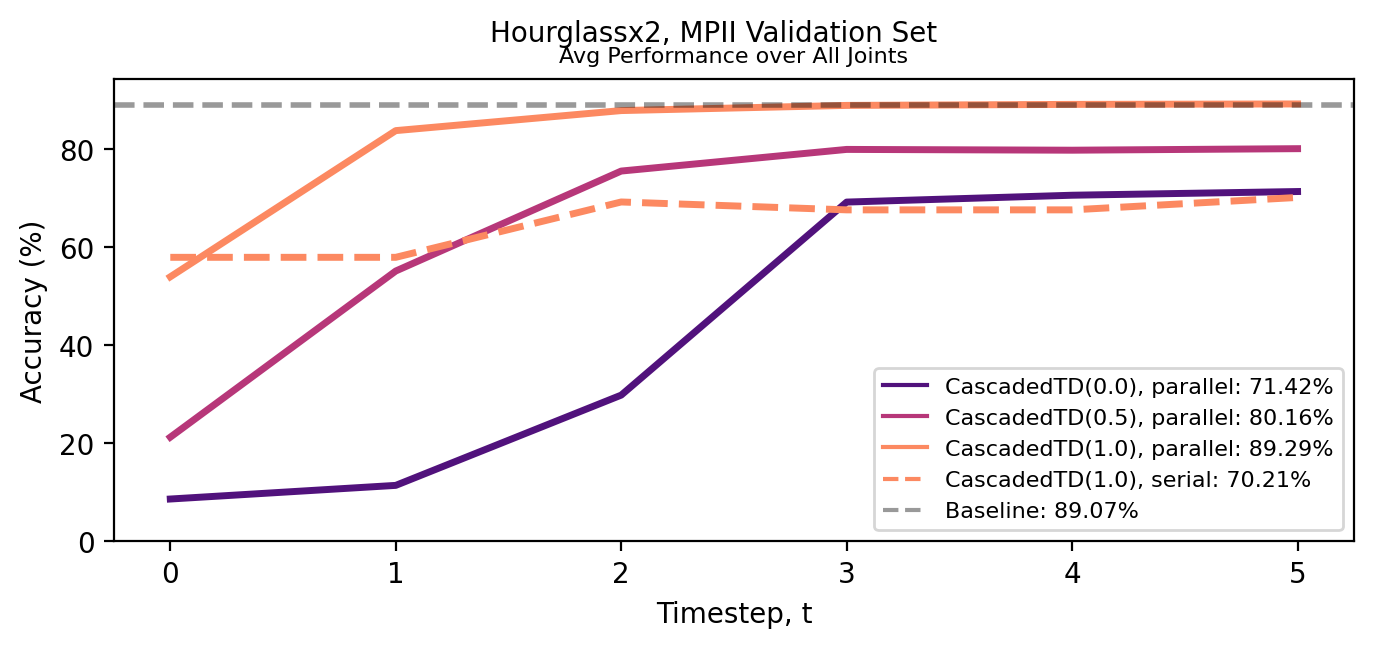

In [239]:
ylim_max = float(df.val.max())
ylim_max += 5

for model_key, model_df in df.groupby("model"):
  td_model_df, baseline_df = split_model(model_df)
  plot_figure(td_model_df, 
              baseline_df, 
              dataset_name=DATASET_NAME, 
              ylim_min=0,
              ylim_max=ylim_max)